In [14]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

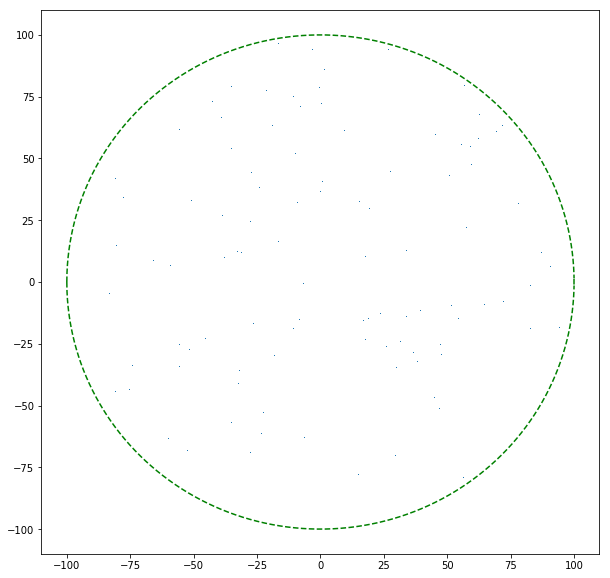

In [15]:
A = 5 
B = 9
N = 100
radius = 100
h = 0.0001 #step
delta = 0.1
alpha= 2
epsilon=0.01

old_coords=coordinates_of_all_points = np.random.normal(loc = (0, 0),size =(N, 2))*radius
old_veloc =velocities_of_all_points = np.random.rand(N, 2)

while (np.sum(np.linalg.norm(coordinates_of_all_points, axis = 1)>radius)>0):
    length = np.sum(np.linalg.norm(coordinates_of_all_points, axis = 1)>radius)
    substitution_matrix = np.random.normal(loc = (0, 0),size =(length, 2))* radius
    coordinates_of_all_points[np.linalg.norm(coordinates_of_all_points, axis = 1)>radius] = substitution_matrix

# print("Coordinates of all points:\n", coordinates_of_all_points, \
#       "\n\nVelocities of all points:\n", velocities_of_all_points)
x_boundary = np.arange(-radius, radius, 0.01)
y_boundary = np.sqrt(radius**2 - x_boundary**2)
plt.figure(figsize=(10,10))
plt.plot(coordinates_of_all_points[:,0], coordinates_of_all_points[:,1], ",")
plt.plot(x_boundary, y_boundary, "g--")
plt.plot([radius, radius], [y_boundary[-1], -y_boundary[-1]], "g--")
plt.plot(x_boundary, -y_boundary, "g--")
plt.show()

In [16]:
# def new_coordinates()

## FMM function: 

In [18]:
def acceleration(eta, epsilon, alpha):
    return (eta / ((np.linalg.norm(eta) + epsilon)**alpha))

In [19]:
eta = np.ones(2)
eta = np.ones(2)
norm_eta = np.sqrt(2)



    
def find_FMM_acceleration(A, B, point_ID, delta_velocity, delta_time, middle=[0, 0]):
    velocity = velocities_of_all_points[point_ID] + delta_velocity #Runge-Kutta
    FMM_accel = (   A-B*np.power(np.linalg.norm(velocity), 2)   )*velocity
    
    x_i = velocity * delta_time + coordinates_of_all_points[point_ID] #Runge-Kutta
    x_i = x_i - middle
    term_1 = acceleration(x_i, epsilon, alpha)   
    
    
    source_IDs = np.arange(N)
    source_IDs = source_IDs[source_IDs != point_ID]
    for body_ID in source_IDs:
        x_j = velocities_of_all_points[body_ID] * delta_time + coordinates_of_all_points[body_ID] #Runge-Kutta
        term_3 = (x_j - middle)/x_i
        FMM_accel += term_1 * (zero_derivative + first_derivative * term_3) 
    return FMM_accel

In [20]:
def force_of_interaction(velocity1, point_ID1, point_ID2, delta_time):
    old_coord_diff = coordinates_of_all_points[point_ID2]- coordinates_of_all_points[point_ID1]
    old_velocity_diff = velocities_of_all_points[point_ID2]- velocity1
    new_coord_diff = old_velocity_diff * delta_time + old_coord_diff
    return new_coord_diff/np.power(np.linalg.norm(new_coord_diff), alpha)

In [21]:
def find_acceleration(point_ID, delta_velocity, delta_time):
    velocity = velocities_of_all_points[point_ID] + delta_velocity
    return (   A-B*np.power(np.linalg.norm(velocity), 2)   )*velocity+\
            np.sum([force_of_interaction(velocity, point_ID, body_ID, delta_time) if body_ID != point_ID else [0, 0] for body_ID in np.arange(N)], axis = 0)

In [22]:
def k_1_computation(A, B, point_ID):
    return h*find_FMM_acceleration(A, B, point_ID, 0, 0)

In [23]:
def k_2_computation(A, B, point_ID):
    return h*find_FMM_acceleration(A, B, point_ID, k_1_computation(A, B, point_ID), h)

In [24]:
def update_velocity(A, B, point_ID):
    return velocities_of_all_points[point_ID] + (k_1_computation(A, B, point_ID) + k_2_computation(A, B, point_ID))/2

In [25]:
def reflection(point_ID):
    p = coordinates_of_all_points[point_ID]
    v = velocities_of_all_points[point_ID]
    HH = v
    if np.dot(v, p) > 0:
        normal_vec = p / np.linalg.norm(p)
        normal_vec = normal_vec.reshape(-1, 1)
        Householder_matrix = np.identity(2) - 2 * normal_vec @ normal_vec.T
        HH = Householder_matrix @ v
    return HH

In [26]:
# velocities_of_all_points = np.asarray([update_velocity(point_ID) for point_ID in np.arange(N)])
# coordinates_of_all_points -= velocities_of_all_points * h

In [27]:
# print("Coordinates of all points:\n", coordinates_of_all_points, \
#       "\n\nVelocities of all points:\n", velocities_of_all_points)


In [13]:
plt.close('all')
arrow_scale = 3

alpha_array = [1]#, 2, 3, 4]
epsilon_array = [1e-4]#, 1e-3, 1e-2, 1e-1]



AB_array = np.arange(0, 10, 1)
diff_time = []
for alpha in alpha_array:
    for epsilon in epsilon_array:
        scalar_coefficient = np.power(norm_eta + epsilon, float(-alpha))
        zero_derivative = eta/scalar_coefficient
        first_derivative = scalar_coefficient * (1 - alpha/(norm_eta + epsilon)/norm_eta)*eta


        for A in AB_array:
            for B in AB_array:
                coordinates_of_all_points = old_coords
                velocities_of_all_points = old_veloc
                time_start = time()
                for j in range(100):
                    plt.close('all')
                    velocities_of_all_points = np.asarray([update_velocity(A, B, point_ID) for point_ID in np.arange(N)])

                    plt.figure(figsize=(10,10))
                    plt.plot(coordinates_of_all_points[:,0], coordinates_of_all_points[:,1], ",")
                    for i in range(N):
                        plt.arrow(coordinates_of_all_points[i,0], coordinates_of_all_points[i,1], velocities_of_all_points[i,0] * arrow_scale, velocities_of_all_points[i,1] * arrow_scale, shape='full', lw=0.5, length_includes_head=True, head_width=1)

                    coordinates_of_all_points += velocities_of_all_points * h

                    indices = coordinates_of_all_points[:,0]**2 + coordinates_of_all_points[:,1]**2 > (radius*(1- delta))**2 

                    point_ID = 0
                    for ind in indices:
                        if ind == True:
                #             plt.plot(x_boundary, y_boundary, "g--")
                #             plt.plot([radius, radius], [y_boundary[-1], -y_boundary[-1]], "g--")
                #             plt.plot(x_boundary, -y_boundary, "g--")
                #             plt.title("Frame #%i. Reflection of %i" % (j, point_ID))
                #             plt.savefig(('images/%i.%i.png'% (j, point_ID)))
                #             plt.show()
                            velocities_of_all_points[point_ID]= reflection(point_ID)            
                #             plt.figure(figsize=(10,10))
                #             plt.plot(coordinates_of_all_points[:,0], coordinates_of_all_points[:,1], ",")
                #             for i in range(N):
                #                 plt.arrow(coordinates_of_all_points[i,0], coordinates_of_all_points[i,1], velocities_of_all_points[i,0] * arrow_scale, velocities_of_all_points[i,1] * arrow_scale, shape='full', lw=0.5, length_includes_head=True, head_width=1)
                        point_ID += 1

                    plt.plot(x_boundary, y_boundary, "g--")
                    plt.plot([radius, radius], [y_boundary[-1], -y_boundary[-1]], "g--")
                    plt.plot(x_boundary, -y_boundary, "g--")
                    plt.title("Frame #%i" % j)
                    plt.savefig(('images3/A=%0.1f B=%0.1f eps=%0.4f alp=%0.1f Frame=%i.png'% (A, B, epsilon, alpha, j) ))
                #     plt.show()

                time_end = time()
                diff_time.append(time_end - time_start)
                print((time_end - time_start))

        
np.savetxt("TIME_A_B_epsilon_alpha.txt", diff_time)
        
        


64.63759779930115
70.27882099151611
69.91925811767578
81.82483506202698
80.8022620677948
69.54840588569641
67.33854603767395
64.24653100967407
84.31438636779785
64.32450890541077
65.21399712562561
62.364534854888916
63.84323477745056
61.93781566619873
59.87411093711853
53.70086598396301
62.12505388259888
50.86473298072815
49.552069902420044
49.17995476722717
53.5371630191803
51.45508098602295
49.1073260307312
50.13756990432739
50.60238194465637
49.48071098327637
51.74983191490173
60.203864097595215
49.86685395240784
54.462708950042725
48.84718894958496
49.23331809043884
50.40182590484619
55.70212697982788


KeyboardInterrupt: 

In [ ]:
a = np.asarray([1, 1])
b = np.asarray([3, 4])
print(np.linalg.norm(eta)== np.sqrt(2))

## Checking

In [33]:


scalar_coefficient = np.power(norm_eta + epsilon, float(-alpha))
zero_derivative = eta/scalar_coefficient
first_derivative = scalar_coefficient * (1 - alpha/(norm_eta + epsilon)/norm_eta)*eta



def find_FMM_acceleration(point_ID, delta_velocity, delta_time, middle=[0, 0]):
    velocity = velocities_of_all_points[point_ID] + delta_velocity #Runge-Kutta
    FMM_accel = (   A-B*np.power(np.linalg.norm(velocity), 2)   )*velocity
    
    x_i = velocity * delta_time + coordinates_of_all_points[point_ID] #Runge-Kutta
    x_i = x_i - middle
    term_1 = acceleration(x_i, epsilon, alpha)   
    
    
    source_IDs = np.arange(N)
    source_IDs = source_IDs[source_IDs != point_ID]
    for body_ID in source_IDs:
        x_j = velocities_of_all_points[body_ID] * delta_time + coordinates_of_all_points[body_ID] #Runge-Kutta
        term_3 = (x_j - middle)/x_i
        FMM_accel += term_1 * (zero_derivative + first_derivative * term_3) 
    return FMM_accel

In [34]:
accel = [find_acceleration(point_ID, 0, 0) for point_ID in np.arange(N)]
FMM_accel = [find_FMM_acceleration(point_ID, 0, 0) for point_ID in np.arange(N)]

In [35]:
accel = np.asarray(accel)
FMM_accel = np.asarray(FMM_accel)

[ 4  9 10 13 14 15 40 41 45 47 48 55 60 65 66 68 70 71 73 77 84 89 90 98] [[-80.45050616  14.50791306]
 [-27.84953636  24.35787747]
 [ -6.93754935  -0.65918421]
 [ 45.30993693  59.41267179]
 [-10.1148998   51.97610656]
 [ 69.3405654   60.73998841]
 [ 39.15035219 -11.53517164]
 [ 15.27833413  32.56375968]
 [ 50.66553011  42.86451963]
 [ 44.82756209 -46.8345861 ]
 [-10.82165178 -18.85584707]
 [-39.05493771  66.33128935]
 [ 23.34981472 -12.86363924]
 [-26.40302397 -16.99676769]
 [ 16.88864612 -15.75317364]
 [ 54.34105238 -14.89737021]
 [  9.32256789  61.07435967]
 [ 36.32105949 -28.69227319]
 [ 17.58945322   9.93034037]
 [ 17.50696196 -23.6127472 ]
 [ 19.17234915  29.4794444 ]
 [-19.28837597  63.00939943]
 [ 31.32578361 -24.17343132]
 [ 29.67892305 -34.91236141]]


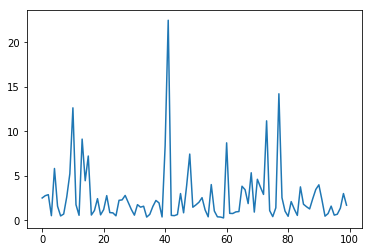

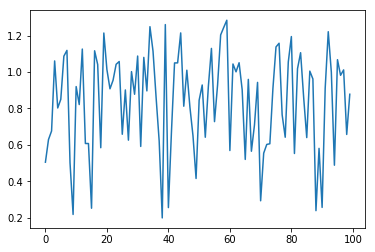

In [44]:
# err = (FMM_accel-accel)/abs(accel)
err = np.linalg.norm(FMM_accel-accel, axis = 1)/np.linalg.norm(accel, axis = 1)
IDs = np.arange(N)
IDs = IDs[err>3]
print(IDs, coordinates_of_all_points[IDs])


plt.plot(err)
plt.show()

vels = np.linalg.norm(velocities_of_all_points, axis = 1)
plt.plot(vels)
# print(vels[IDs])
plt.show()